In [13]:
import nbimporter
from main import *
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from datetime import datetime
from pyspark.sql.functions import desc, col
import geopandas as gpd
import shapely.geometry

In [2]:
"""
    THIS FILE REFERS TO TESTS AND PRE-ANALYSES IN ORDER TO UNDERSTAND THE DATA CONTENT.
    IT SHOULD BE EXECUTED ONLY AFTER THE MAIN FILE.
"""

spark = SparkSession.builder.getOrCreate()
df = spark.read.csv("cl_data.csv", header=True, inferSchema=True)

In [3]:
# Receive the SHP file for importing the maps, transform it into a Pandas DataFrame, and check the columns related to the address (logradouro)
# to enable proper cleaning of the addresses and linking the accident table columns to the map.

shp_file = "EixosLogradouros/EixosLogradouros.shp"
gdf = gpd.read_file(shp_file)

def get_wkt(geom):
    if geom is not None and isinstance(geom, shapely.geometry.base.BaseGeometry):
        return geom.wkt
    else:
        return None

df_pandas_geo = gdf.drop('geometry', axis=1).copy()
df_pandas_geo['geometry'] = gdf['geometry'].apply(get_wkt)
print(df_pandas_geo.head())

filtered_df = df.filter(~(col('log1').like('R%') | col('log1').like('AV%') | col('log1').like('ESTR%')) & (col('log1') != '')).limit(10)
filtered_df.select('log1').show(10)

     CDLOG   CDSEG  NRIMPINI  NRIMPFIN  NRPARINI  NRPARFIN     MTORIGEM  \
0  8661019  511241         1       471         2       470  BASE 1:1000   
1  8663593  510877         1        81         2        60  BASE 1:1000   
2  8660094  514378         1       489         2       488       IMAGEM   
3  8562175  514620         1       145         2       110       IMAGEM   
4  8662199  510968         1       157         2       134  BASE 1:1000   

      MTQUAL  CDTIPO MTVETOR  FGCOMP  SEL  LABEL  CDIDELOG  \
0  CONFIAVEL       0  MOVIDO     1.0    3      1   8661019   
1  CONFIAVEL       0  MOVIDO     1.0    1      0   8663593   
2  CONFIAVEL       0  MOVIDO     1.0    1      1   8660094   
3  CONFIAVEL       0  MOVIDO     1.0    1      1   8562175   
4  CONFIAVEL       0  MOVIDO     1.0    1      1   8662199   

                    NMIDELOG CDIDECAT NMIDEPRE          NMIDEABR  GEOM_LEN  \
0           CHACARA DO BANCO       BC      NaN  BC CHAC DO BANCO       0.0   
1  MANOEL FERNANDES 

In [4]:
# Import the DataCleaning class, read the file into another Pandas DataFrame to perform the checks between the columns related to the address (log1 and NMIDELOG)

dc = DataCleaning(df)
df_pandas = pd.read_csv('cl_data.csv')
print("- Columns in df_pandas: ", df_pandas.columns)


missing_items = df_pandas[~df_pandas['log_cleaned'].isin(df_pandas_geo['NMIDELOG'])]
missing_items = missing_items['log_cleaned'].unique()
print("- How many items don't match in both columns: ", len(missing_items))

# Check if an especific address value is present in both columns
CHECK_WORD = 'PROTASIO ALVES'

contains_df_pandas_geo = CHECK_WORD in df_pandas_geo['NMIDELOG'].values
if contains_df_pandas_geo:
    print(f"- O valor {CHECK_WORD} está presente na coluna 'NMIDELOG'.")
else:
    print(f"- O valor {CHECK_WORD} não está presente na coluna 'NMIDELOG'.")

contains_df_pandas = df_pandas['log_cleaned'].str.contains(CHECK_WORD).any()
if contains_df_pandas:
    print(f"- O valor {CHECK_WORD} está presente na coluna 'log_cleaned'.")
else:
    print(f"- O valor {CHECK_WORD} não está presente na coluna 'log_cleaned'.")

- Columns in df_pandas:  Index(['id', 'data', 'hora', 'idade', 'sexo', 'sit_vitima', 'log1', 'regiao',
       'tipo_acid', 'auto', 'taxi', 'onibus_urb', 'onibus_met', 'onibus_int',
       'caminhao', 'moto', 'carroca', 'bicicleta', 'outro', 'lotacao',
       'dia_sem', 'periododia', 'fx_et', 'log_cleaned'],
      dtype='object')
- How many items don't match in both columns:  3
- O valor PROTASIO ALVES está presente na coluna 'NMIDELOG'.
- O valor PROTASIO ALVES está presente na coluna 'log_cleaned'.


In [5]:
# Count the occurrence of each log1 type
top_log1 = df.groupBy('log1').count().orderBy(col('count').desc()).limit(10)
top_log1.show(10)

# Filter the first 300 items in log1 that do not start with the words below and are not blank to check for possible formatting/typing errors
filtered_df = df.filter(
    ~(col('log1').like('R%') |
      col('log1').like('AV%') |
      col('log1').like('ESTR%') |
      col('log1').startswith('TUN') |
      col('log1').startswith('BC') |
      col('log1').startswith('TRAV') |
      col('log1').startswith('AL') |
      col('log1').startswith('LG') |
      col('log1').startswith('PSG') |
      col('log1').startswith('PCA') |
      col('log1').startswith('VDT') |
      col('log1').startswith('PRQ') |
      col('log1').startswith('AC')) 
    & (col('log1') != '')
).limit(10)


+--------------------+-----+
|                log1|count|
+--------------------+-----+
|   AV PROTASIO ALVES| 1417|
|  AV BENTO GONCALVES| 1185|
|     AV ASSIS BRASIL| 1025|
|         AV IPIRANGA|  985|
|         AV SERTORIO|  746|
|AV PROF OSCAR PER...|  664|
|ESTR JOAO DE OLIV...|  574|
|AV BALTAZAR DE OL...|  511|
|ESTR JOAO ANTONIO...|  438|
|     AV JUCA BATISTA|  435|
+--------------------+-----+



In [6]:
# Creating a list of the most frequent words to check for variations in different contexts due to formatting/typing errors
words_to_check = ['BORGES', 'PROTASIO', 'ASSIS', 'IPIRANGA', 'FARRAPOS', 'COSTA', 'NIEMEYER', 'LIMA']

df_with_words = df.filter(col('log1').rlike(r'\b(' + '|'.join(words_to_check) + r')\b'))

for word in words_to_check:
    df_word = df_with_words.withColumn('context', regexp_extract(col('log1'), r'(.*' + word + r'.*)', 1))
    count_per_context = df_word.groupBy('context').agg(count('*').alias('occurrences')).orderBy(col('occurrences').desc())
    print(f"Word: {word}")
    count_per_context.show(truncate=False)
    print()

Word: BORGES
+---------------------------------+-----------+
|context                          |occurrences|
+---------------------------------+-----------+
|                                 |4479       |
|AV CEL APARICIO BORGES           |244        |
|AV BORGES DE MEDEIROS            |189        |
|R GEN JONATHAS BORGES FORTES     |6          |
|ESTR ANTONIO BORGES              |6          |
|R PASTOR DORIVAL BORGES MARTINS  |1          |
|R BORGES DO CANTO                |1          |
|R PROF LUIZINHA W BORGES FORTES  |1          |
|TRAV SAO JOAO-CEL APARICIO BORGES|1          |
+---------------------------------+-----------+


Word: PROTASIO
+------------------------------+-----------+
|context                       |occurrences|
+------------------------------+-----------+
|                              |3509       |
|AV PROTASIO ALVES             |1417       |
|R QUATRO JARDIM PROTASIO ALVES|1          |
|R SETE  JARDIM PROTASIO ALVES |1          |
+------------------------------

In [7]:
# Count the occurrences of each category in the "sit_vitima" column
count_per_sit_vitima = df.groupBy('sit_vitima').agg(count('*').alias('ocorrencias')).orderBy(col('ocorrencias').desc())
count_per_sit_vitima.show(truncate=False)

# Count how many items have null values in each column
columns = df.columns

for column in df.columns:
    count_nulls = df.filter(col(column).isNull()).count()
    print(f"The number of items with null values in {column} is: {count_nulls}")

+-------------+-----------+
|sit_vitima   |ocorrencias|
+-------------+-----------+
|CONDUTOR     |19785      |
|OCUPANTE     |5367       |
|PEDESTRE     |3849       |
|NAO INFORMADO|201        |
|NAOINFORMADO |169        |
|null         |51         |
+-------------+-----------+

The number of items with null values in id is: 0
The number of items with null values in data is: 0
The number of items with null values in hora is: 97
The number of items with null values in idade is: 3539
The number of items with null values in sexo is: 1
The number of items with null values in sit_vitima is: 51
The number of items with null values in log1 is: 0
The number of items with null values in regiao is: 0
The number of items with null values in tipo_acid is: 0
The number of items with null values in auto is: 0
The number of items with null values in taxi is: 0
The number of items with null values in onibus_urb is: 0
The number of items with null values in onibus_met is: 0
The number of items with nu

In [8]:
# ___PRE-ANALYSIS CONFIGS

# Format the current date and time:
locale.setlocale(locale.LC_TIME, 'pt_BR.utf8')
current_datetime = datetime.now()
current_month = current_datetime.strftime('%B')
formatted_month = current_month.capitalize()
current_month_number = current_datetime.month
month_names = calendar.month_name
now = current_datetime.strftime("%d de {} de %Y").format(month_names[current_month_number])
print("Done")

Done


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


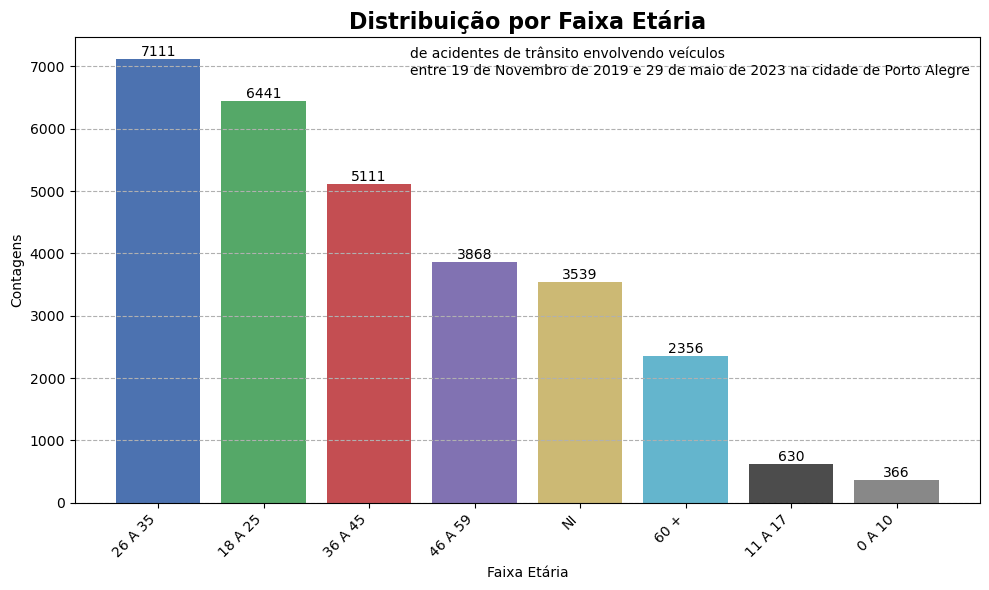

In [9]:
# ___1ST ANALYSIS - BY GROUP AGE

# group by age range and count occurrences
age_counts = df.groupBy("fx_et").count()
age_counts = age_counts.orderBy(desc("count"))

# Plot:
bar_colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974', '#64B5CD', '#4C4C4C', '#888888']
x_values = [row["fx_et"] for row in age_counts.collect()]
y_values = [row["count"] for row in age_counts.collect()]

plt.figure(figsize=(10, 6))

# Plotar o gráfico de barras
plt.bar(x_values, y_values, color=bar_colors)
for i in range(len(x_values)):
    plt.text(x_values[i], y_values[i], str(y_values[i]), ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')
plt.xlabel('Faixa Etária')
plt.ylabel('Contagens')
plt.title('Distribuição por Faixa Etária', fontsize=16, fontweight='bold')
plt.legend(title=f'de acidentes de trânsito envolvendo veículos\nentre 19 de Novembro de 2019 e {now} na cidade de Porto Alegre', loc='upper right', fontsize=8, frameon=False)

plt.grid(axis='y', linestyle='--')
plt.subplots_adjust(top=0.85, bottom=0.15)
plt.tight_layout()
plt.show()

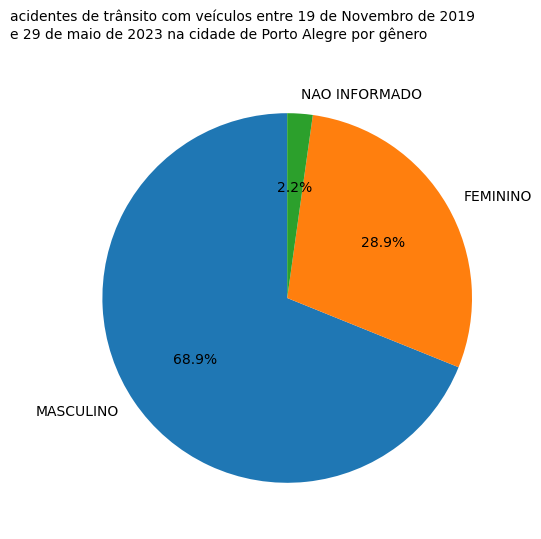

In [15]:
# ___2ND ANALYSIS - BY GENDER

# Filter out rows where gender is blank
filtered_df_gender = df.filter(df['sexo'] != '')
gender_counts = filtered_df_gender.groupBy('sexo').count().orderBy(desc("count"))

# Plot:
values = [row['count'] for row in gender_counts.collect()]
labels = [row['sexo'] for row in gender_counts.collect()]

# Configurar o tamanho da figura
plt.figure(figsize=(6, 6))

# Plotar o gráfico de pizza
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)

# Adicionar título ao gráfico
plt.text(-1.5, 1.5, f'acidentes de trânsito com veículos entre 19 de Novembro de 2019', fontsize=10)
plt.text(-1.5, 1.4, f'e {now} na cidade de Porto Alegre por gênero', fontsize=10)

# Exibir o gráfico
plt.show()

In [11]:
# ___3RD ANALYSIS - BY TYPE OF ACCIDENT

type_acc = df.groupBy("tipo_acid").count()
type_acc.show()

+--------------+-----+
|     tipo_acid|count|
+--------------+-----+
|  ABALROAMENTO|13173|
|NAO CADASTRADO| 1195|
|      INCÊNDIO|    1|
| ATROPELAMENTO| 4138|
|        CHOQUE| 2188|
|    TOMBAMENTO|   56|
|     CAPOTAGEM|  229|
|      EVENTUAL|  279|
|         QUEDA| 2090|
|       COLISÃO| 6073|
+--------------+-----+



In [12]:
# ___4TH ANALYSIS - PER YEAR

# Extract the year from a date column 
df = df.withColumn('ano', year(col('data')))

# Count the number of registers per year
count_by_year = df.groupBy('ano').agg(F.count('*').alias('total')).orderBy('ano')
count_by_year.show()

+----+-----+
| ano|total|
+----+-----+
|2018| 5270|
|2019| 5778|
|2020| 4592|
|2021| 5490|
|2022| 6159|
|2023| 2130|
|2026|    3|
+----+-----+

